In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import numpy as np
from PIL import Image
#!pip install tensorflow
import tensorflow as tf
from sklearn.model_selection import train_test_split
from hashlib import md5
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout,BatchNormalization, Dense, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
#!pip install kaggle

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d dansbecker/food-101 -p /content/drive/MyDrive/food-101 --unzip

In [ ]:
#!kaggle datasets download -d dansbecker/food-101 -p /content/drive/MyDrive/food-101

In [ ]:
#!unzip /content/drive/MyDrive/food-101/food-101.zip -d /content/drive/MyDrive/food-101

In [ ]:
data_path = "/content/drive/MyDrive/food-101/food-101/food-101"

print(os.listdir(data_path))

['license_agreement.txt', 'images', 'meta', 'README.txt']


In [ ]:

#!rm -rf /content/drive/MyDrive/food-101/food-101.zip


In [ ]:
if os.path.exists(os.path.join(data_path, ".DS_Store")):
  os.remove(os.path.join(data_path, ".DS_Store"))

In [ ]:
print(os.listdir(data_path))

['license_agreement.txt', 'images', 'meta', 'README.txt']


In [ ]:
if "images" in os.listdir(data_path):
  final_path = data_path
elif "images" in os.listdir("/content/drive/MyDrive/food-101"):
  final_path = "/content/drive/MyDrive/food-101"
elif "images" in os.listdir("/content/drive/MyDrive/food-101/food-101"):
  final_path = "/content/drive/MyDrive/food-101/food-101"
else:
  raise FileNotFoundError("Неверная структура данных!")
print("Путь к данным:", final_path)

Путь к данным: /content/drive/MyDrive/food-101/food-101/food-101


In [ ]:
images_dir = os.path.join(final_path, "images")
class_names = sorted(os.listdir(images_dir))
if ".DS_Store" in class_names:
  class_names.remove(".DS_Store")
print(f"The num of classes {len(class_names)}")
class_to_index = {name : idx for idx, name in enumerate(class_names)}

The num of classes 101


In [ ]:
def load_split(split_name):
  with open(os.path.join(final_path, "meta", f"{split_name}.txt"), "r") as f:
    return [line.strip() for line in f.readlines()]

train_samples = load_split("train")
test_samples = load_split("test")

train_samples, val_samples = train_test_split(train_samples, test_size=0.1, random_state=42)
print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")
print(f"test samples: {len(test_samples)}")

Train samples: 68175
Val samples: 7575
test samples: 25250


In [ ]:
class_counts = defaultdict(int)
for sample in train_samples + test_samples:
  class_name = sample.split("/")[0]
  class_counts[class_name] +=1

df_classes = pd.DataFrame({
    "Class" : list(class_counts.keys()),
    "Images": list(class_counts.values())
})

In [ ]:
df_classes.tail(5)

,Class,Images
96,french_onion_soup,919
97,dumplings,931
98,eggs_benedict,934
99,garlic_bread,940
100,takoyaki,932


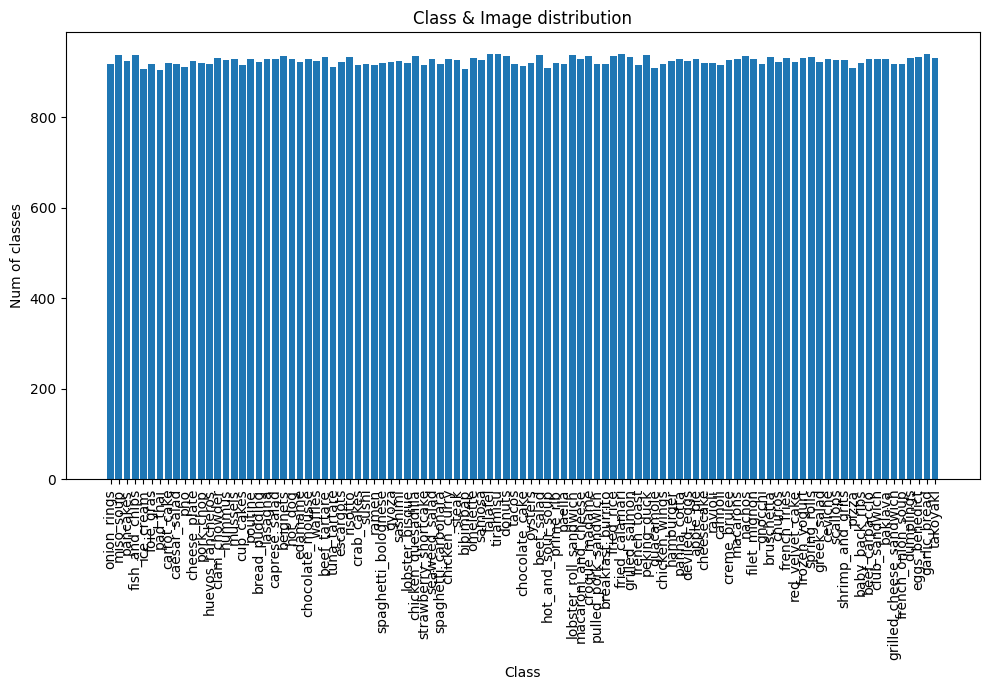

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(df_classes["Class"], df_classes["Images"])
plt.title("Class & Image distribution")
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Num of classes")
plt.tight_layout()
plt.show()

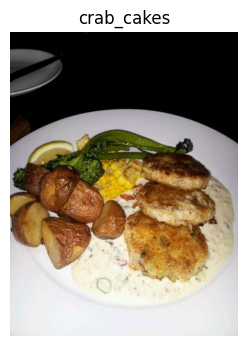

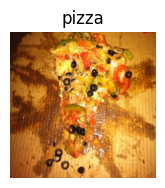

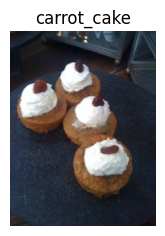

In [ ]:
def plot_random_pics(n=5):
  plt.figure(figsize=(10,7))
  for i in range(n):
    class_name = np.random.choice(df_classes["Class"])
    image_name = np.random.choice(os.listdir(os.path.join(data_path, "images", class_name)))
    image_path = os.path.join(data_path, "images", class_name, image_name)
    try:
      img = Image.open(image_path)
      plt.subplot(1,n,i+1)
      plt.imshow(img)
      plt.title(class_name)
      plt.axis("off")
    except Exception as e:
      print(f"The Error with opening {image_path}: {e}")
    plt.show()

plot_random_pics(3)

In [ ]:
def analyze_image_sizes(num_samples=100):
  heights, widths = [], []
  for _ in range(100):
    class_name = np.random.choice(df_classes['Class'])
    image_name = np.random.choice(os.listdir(os.path.join(data_path, "images", class_name)))
    image_path = os.path.join(data_path, "images", class_name, image_name)
    try:
      with Image.open(image_path) as img:
        widths.append(img.width)
        heights.append(img.height)
    except Exception as e:
      print(f"The Error with opening {image_path}: {e}")
  return heights, widths

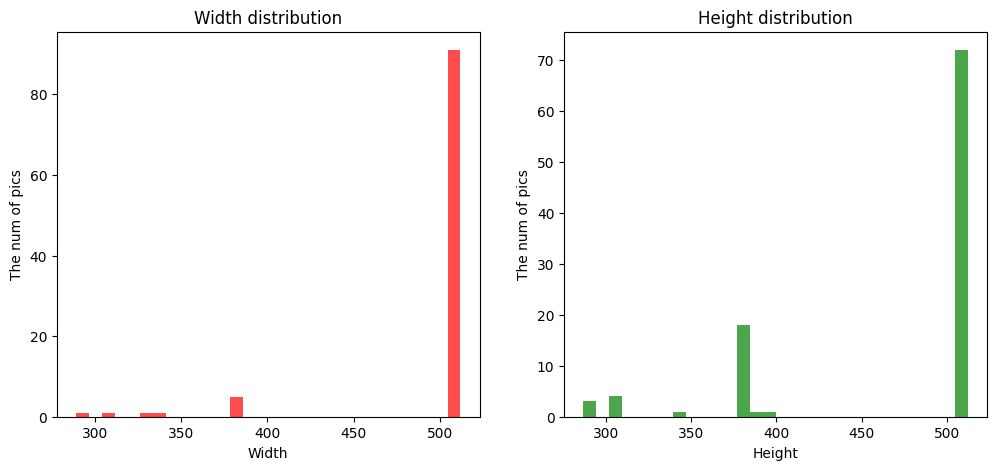

In [ ]:
heights, widths = analyze_image_sizes(100)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='red', alpha=0.7)
plt.xlabel("Width")
plt.ylabel("The num of pics")
plt.title("Width distribution")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title("Height distribution")
plt.xlabel("Height")
plt.ylabel("The num of pics")
plt.show()

In [ ]:
def detect_duplicates(sample_size=1000, dataset_path=images_dir):
  hashes = defaultdict(list)
  duplicates = []
  image_paths = []

  for cls in class_names:
    cls_dir = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_dir):
      image_paths.append(os.path.join(cls_dir, img_name))
  if sample_size > len(image_paths):
    sample_size = len(image_paths)
  sampled_paths = np.random.choice(image_paths, sample_size, replace=False)
  for path in sampled_paths:
    try:
      with open(path, 'rb') as f:
        file_hash = md5(f.read()).hexdigest()
      if file_hash in hashes:
        duplicates.append(path)
      else:
        hashes[file_hash].append(path)
    except Exception as e:
      print(f"Error with opening {path}: {e}")
  return duplicates
duplicates = detect_duplicates(1000, images_dir)

In [ ]:
def show_duplicates(duplicates, n=5):
  for i in range(n):
    img = Image.open(duplicates[i])
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.title(f"Duplicate {i+1}")
    plt.axis("off")
  plt.show()

if len(duplicates) > 0:
  show_duplicates(duplicates)
else:
  print("There are no duplicates")

There are no duplicates


In [ ]:
def show_duplicate_classes(duplicates):
  duplicate_classes = defaultdict(int)
  for path in duplicates:
    class_name = path.split("/")[-2]
    duplicate_classes[class_name] +=1
  print("Duplicates in classes:")
  for cls, count in duplicate_classes.items():
    print(f"- {cls}: {count}")

In [ ]:
def remove_duplicate_files(duplicates):
  for file_path in duplicates:
    try:
      os.remove(file_path)
      print(f"{file_path} was removed successfuly")
    except Exception as e:
      print(f"Error with deleting {file_path}")

In [ ]:
def preprocess_image(image_path, img_size=(300,300)):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, img_size)
  img = tf.keras.applications.efficientnet.preprocess_input(img)
  return img

sample_image = os.path.join(images_dir, "apple_pie",os.listdir(os.path.join(images_dir, "apple_pie"))[0])
processed_img = preprocess_image(sample_image)
print(f"The size of preprocessing: {processed_img.shape}")

The size of preprocessing: (300, 300, 3)


In [ ]:
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])


In [ ]:
def get_images_paths(split_samples):
    paths = []
    for sample in split_samples:
        try:
            cls, img_file = sample.split("/")
            img_path = os.path.join(images_dir, cls, img_file + ".jpg")
            if os.path.exists(img_path):
                paths.append(img_path)
        except:
            print(f"Ошибка в формате образца: {sample}")
    return paths
train_image_paths = get_images_paths(train_samples)
val_image_paths = get_images_paths(val_samples)
test_image_paths = get_images_paths(test_samples)
print(f"The size of train dataset: {len(train_image_paths)}")
print(f"The size of test dataset: {len(test_image_paths)}")

The size of train dataset: 68175
The size of test dataset: 25250


In [ ]:
keys = tf.constant(list(class_to_index.keys()))
vals = tf.constant(list(class_to_index.values()), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(keys, vals)
class_lookup = tf.lookup.StaticHashTable(table_init, default_value=-1)

In [ ]:
def load_and_preprocess(path, img_size=(300, 300)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    parts = tf.strings.split(path, os.sep)
    label_str = parts[-2]
    label_idx = class_lookup.lookup(label_str)
    label_idx = tf.reshape(label_idx, ())
    label = tf.one_hot(label_idx, depth=101)
    label = tf.reshape(label, (101,))

    return img, label

In [ ]:
def create_dataset(image_paths, batch_size=64, img_size=(300, 300), shuffle=True, augment=False):
  ds = tf.data.Dataset.from_tensor_slices(image_paths)
  if shuffle:
    ds = ds.shuffle(buffer_size=len(image_paths))
  ds = ds.map(lambda x: load_and_preprocess(x, img_size), num_parallel_calls = tf.data.AUTOTUNE)
  ds = ds.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, -1)))
  if augment:
    ds = ds.map(lambda img, label: (data_augmentation(img, training=True), label), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_ds = create_dataset(train_image_paths, batch_size=64, img_size=(300, 300), shuffle=True, augment=True)
val_ds = create_dataset(val_image_paths, batch_size=64, img_size=(300, 300), shuffle=False, augment=False)
test_ds = create_dataset(test_image_paths, batch_size=64, img_size=(300, 300), shuffle=False, augment=False)

In [ ]:
print("Datasets are set!")

Datasets are set!


In [ ]:
def build_model(input_shape=(300, 300,3), num_classes=101, base_trainable=False):
  inputs = Input(shape=input_shape)
  base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
  base.trainable = base_trainable
  x = base(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs, outputs)
  return model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor="val_loss", mode='min', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [ ]:
batch_size = 32
initial_epochs = 10
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
steps_per_epoch = len(train_image_paths) // batch_size

In [ ]:
model = build_model(input_shape=(300,300,3), num_classes=101, base_trainable=False)
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=steps_per_epoch * 10,
    t_mul=2,
    m_mul=0.9)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
"""model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])"""

"model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])"

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         155,237 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,944,916 (41.75 MB)

 Trainable params: 158,309 (618.39 KB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
model.compile(optimizer= Adam(learning_rate=lr_schedule ),
              loss= CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks,
    steps_per_epoch=max(1, len(train_image_paths) // batch_size)
)

Epoch 1/10
 297/2130 ━━━━━━━━━━━━━━━━━━━━ 2:22:25 5s/step - accuracy: 0.0239 - loss: 5.2025

In [ ]:
for layer in model.layers[1].layers:
    layer.trainable = True
lr_schedule_ft = CosineDecayRestarts(
    initial_learning_rate=1e-5,
    first_decay_steps=(len(train_image_paths) // batch_size) * fine_tune_epochs,
    t_mul=2,
    m_mul=0.9
)
model.compile(optimizer=Adam(learning_rate=lr_schedule_ft),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks
)

Epoch 11/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 610s 430ms/step - accuracy: 0.3256 - loss: 3.2381 - val_accuracy: 0.5525 - val_loss: 2.3362 - learning_rate: 9.9846e-06
Epoch 12/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 378s 355ms/step - accuracy: 0.4933 - loss: 2.5620 - val_accuracy: 0.6110 - val_loss: 2.1546 - learning_rate: 9.9383e-06
Epoch 13/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 380s 356ms/step - accuracy: 0.5528 - loss: 2.3549 - val_accuracy: 0.6358 - val_loss: 2.0639 - learning_rate: 9.8616e-06
Epoch 14/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 381s 357ms/step - accuracy: 0.5918 - loss: 2.2284 - val_accuracy: 0.6570 - val_loss: 1.9913 - learning_rate: 9.7548e-06
Epoch 15/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 381s 357ms/step - accuracy: 0.6216 - loss: 2.1349 - val_accuracy: 0.6713 - val_loss: 1.9489 - learning_rate: 9.6187e-06
Epoch 16/30
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 380s 356ms/step - accuracy: 0.6358 - loss: 2.0741 - val_accuracy: 0.6870 - val_loss: 1.8953 - learning_rate: 9.4540e-06
Epoch 17/30
1066/1066 

In [ ]:
model = keras.models.load_model('best_model.keras')
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
m_frame = pd.DataFrame(history.history)
m_frame_ft = pd.DataFrame(history_ft.history)
plt.figure(figsize=(12, 5))
plt.plot(list(m_frame['loss']) + list(m_frame_ft['loss']), label='loss')
plt.plot(list(m_frame['val_loss']) + list(m_frame_ft['val_loss']), label='val_loss')
plt.title('loss vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
!git clone https://github.com/Norsaje/CNN_Food_classifier.git

fatal: destination path 'CNN_Food_classifier' already exists and is not an empty directory.


In [3]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/food_classifier.ipynb" /content/CNN_Food_classifier/

In [4]:
%cd /content/CNN_Food_classifier

/content/CNN_Food_classifier


In [5]:
!git add .

In [6]:
!git config --global user.email "kirillzinchenko2006@gmail.com"
!git config --global user.name "Norsaje"

In [7]:
!git commit -m "Add model file"

[main e160b76] Add model file
 1 file changed, 1 insertion(+), 1 deletion(-)


In [8]:
!git push origin

fatal: could not read Password for 'https://ghp_Abc123...@github.com': No such device or address
